In [ ]:

#Merge hourly sentiment of Bitcoin tweets with Bitcoin historical prices based on timestamps.
import pandas as pd

df1 = pd.read_csv('/content/drive/MyDrive/Dataset /Cleaned_data/Sentiment.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Dataset /Cleaned_data/bitcoin_historical_prices.csv')


merged_df = pd.merge(df1, df2, on='Datetime', how='inner')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/Dataset /Merged_data/merged_file.csv', index=False)


In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
import nltk
import csv
import requests
from datetime import datetime, timedelta
from dateutil.parser import parse


nltk.download('vader_lexicon')

plt.style.use('fivethirtyeight')

chunk = pd.read_csv('/content/drive/MyDrive/Dataset /raw_data/Bitcoin_tweets.csv', chunksize=100000,lineterminator='\n')
f = pd.concat(chunk)


#removing duplicates
f.drop_duplicates(inplace = True)
f.reset_index(drop=True,inplace=True)
print("Shape after removing duplicates :",f.shape)

# Convert 'date' column to datetime
f['date'] = pd.to_datetime(f['date'], errors='coerce')

# Drop rows with invalid datetime values
f = f.dropna(axis=0 ,subset=['date','text'])
f.reset_index(drop= True,inplace=True)
print("Shape after droping invalid datetime value :",f.shape)


# Text Cleaning
def clean_tweet(twt):
    twt = re.sub('#bitcoin', 'bitcoin', twt, flags=re.IGNORECASE)
    twt = re.sub('#Bitcoin', 'bitcoin', twt, flags=re.IGNORECASE)
    twt = re.sub('#btc', 'bitcoin', twt, flags=re.IGNORECASE)
    twt = re.sub('#[A-Za-z0-9]+', '', twt)
    twt = re.sub(r'\n', '', twt)
    twt = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', twt, flags=re.MULTILINE)
    twt = re.sub('@\\w+ *', '', twt, flags=re.MULTILINE)
    return twt

f['CleanTwt'] = f['text'].apply(clean_tweet)

# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
f['Sentiment'] = f['CleanTwt'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Create a new DataFrame with only 'date' and 'Sentiment'
hourly_sentiment = f[['date', 'Sentiment']].copy()

# Group by hour and calculate mean sentiment scores
hourly_sentiment['Datetime'] = hourly_sentiment['date'].dt.floor('h')
hourly_sentiment = hourly_sentiment.groupby('Datetime')['Sentiment'].mean().reset_index()

# Create a complete date range from the minimum to maximum date
full_date_range = pd.date_range(hourly_sentiment['Datetime'].min(), hourly_sentiment['Datetime'].max(), freq='H')

# Merge with the complete date range to fill missing hours
hourly_sentiment_complete = pd.DataFrame({'Datetime': full_date_range})
hourly_sentiment_complete = pd.merge(hourly_sentiment_complete, hourly_sentiment, on='Datetime', how='left')

# Use linear interpolation to fill missing values
hourly_sentiment_complete['Sentiment'] = hourly_sentiment_complete['Sentiment'].interpolate(method='linear')

# Save the results to a CSV file
hourly_sentiment_complete.to_csv('/content/drive/MyDrive/Dataset /Cleaned_data/Sentiment.csv', index=False)
print("Bitcoin Tweet Sentiment saved to CSV successfully.")


# Filter the data for the last 90 days
end_date = hourly_sentiment_complete['Datetime'].max()+timedelta(hours=1)  # Get the latest date in the dataset
start_date = end_date - timedelta(days=90)

#Bitcoin historical prices for the past 90 days based on Bitcoin Tweet Sentiment.
def get_bitcoin_historical_prices(start_date, end_date):
  url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range'
  params = {
      'vs_currency': 'inr',
      'from': int(start_date.timestamp()),
      'to': int(end_date.timestamp()),
      # 'interval': 'hourly',
  }

  response = requests.get(url, params=params)

  if response.status_code == 200:
    data = response.json()
    prices = data.get('prices', [])
    return prices
  else:
    print(f"Error: {response.status_code}")
    print(response.text)
    return None

def save_bitcoin_historical_prices_to_csv(prices, filename):
  with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Datetime', 'Price (INR)'])

    for timestamp, price in prices:
      formatted_time = parse(datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')).replace(minute=0, second=0, microsecond=0)
      writer.writerow([formatted_time, price])

if __name__ == "__main__":

  prices = get_bitcoin_historical_prices(start_date, end_date)

  if prices is not None:
    save_bitcoin_historical_prices_to_csv(prices, '/content/drive/MyDrive/Dataset /Cleaned_data/bitcoin_historical_prices.csv')
    print("Bitcoin historical prices saved to CSV successfully.")
  else:
    print("Failed to fetch Bitcoin historical prices data.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.concat(chunk)
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.concat(chunk)
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.concat(chunk)
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.concat(chunk)
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  f = pd.concat(chunk)
<ipython-input-1-6aa38de08150>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory

Shape after removing duplicates : (4689354, 13)
Shape after droping invalid datetime value : (4689288, 13)


<ipython-input-1-6aa38de08150>:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(hourly_sentiment['Datetime'].min(), hourly_sentiment['Datetime'].max(), freq='H')


Bitcoin Tweet Sentiment saved to CSV successfully.
Error: 401
{"error":{"status":{"timestamp":"2024-12-13T18:36:19.626+00:00","error_code":10012,"error_message":"Your request exceeds the allowed time range. Public API users are limited to querying historical data within the past 365 days. Upgrade to a paid plan to enjoy full historical data access: https://www.coingecko.com/en/api/pricing. "}}}
Failed to fetch Bitcoin historical prices data.


In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

def create_model(window_size, dropout, x_train):
    model = Sequential()
    model.add(LSTM(window_size, return_sequences=True,input_shape=(window_size, x_train.shape[-1])))
    model.add(Dropout(rate=dropout))
    model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True)))
    model.add(Dropout(rate=dropout))
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 718ms/step - loss: 0.1168 - mae: 0.1168 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0195 - val_mae: 0.0195
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 679ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 671ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 672ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0074 - val_mae: 0.0074
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 685ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 672ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0061 - val_mae: 0.0061
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 668ms/

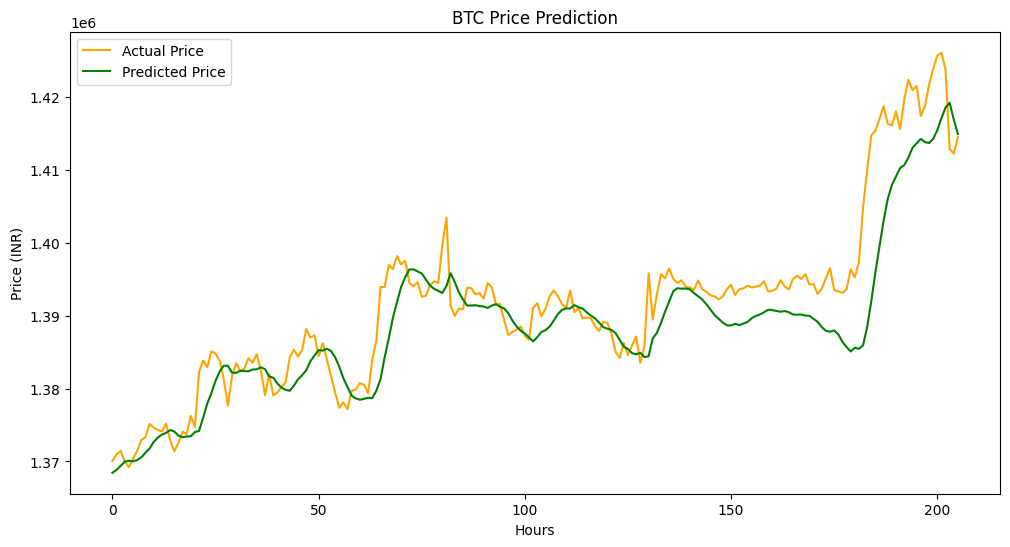

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Ada
m
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset /Merged_data/merged_file.csv')

# Add Moving Average as an additional feature
df['MA_7'] = df['Price (INR)'].rolling(window=7).mean()
df['MA_14'] = df['Price (INR)'].rolling(window=14).mean()
df = df.dropna()

# Preprocess the data
scaler = MinMaxScaler()
price_sentiment_ma = df[['Price (INR)', 'Sentiment', 'MA_7', 'MA_14']].values
scaled_data = scaler.fit_transform(price_sentiment_ma)

# Hyperparameters
seq_len = 100
dropout = 0.3
window_size = seq_len - 1
learning_rate = 0.001

# Function to split data into sequences
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i + seq_len)] for i in range(n_seq)])

# Get train-test sets
def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, 0]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, 0]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_data, seq_len, train_frac=0.9)

# Create the model
def create_model(window_size, dropout, learning_rate, x_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(window_size, x_train.shape[-1]))))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
    return model

model = create_model(window_size, dropout, learning_rate, x_train)

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Make predictions
y_pred = model.predict(x_test)

# Invert scaling
y_test_price = y_test.reshape(-1, 1)
y_pred_price = y_pred.reshape(-1, 1)

y_test_orig = scaler.inverse_transform(np.hstack([y_test_price, np.zeros((y_test_price.shape[0], 3))]))[:, 0]
y_pred_orig = scaler.inverse_transform(np.hstack([y_pred_price, np.zeros((y_pred_price.shape[0], 3))]))[:, 0]

# Calculate RMSE and R2 Score
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
plt.title('BTC Price Prediction')
plt.xlabel('Hours')
plt.ylabel('Price (INR)')
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/Dataset /results.png')
plt.show()


In [ ]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
# from model import create_model
warnings.filterwarnings('ignore')
# plt.style.use('seaborn-poster')

df=pd.read_csv('/content/drive/MyDrive/Dataset /Merged_data/merged_file.csv')

scaler = MinMaxScaler()

price_sentiment = df[['Price (INR)', 'Sentiment']].values
scaled_price_sentiment = scaler.fit_transform(price_sentiment)

# Divide the data into shorter-period sequences
seq_len = 60
batch_size = 16
dropout = 0.4
window_size = seq_len - 1

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_price_sentiment, seq_len, train_frac=0.9)
# fraction of the input to drop; helps prevent overfitting

# Build a 3-layer LSTM RNN
model = create_model(window_size, dropout, x_train)


# Define the ModelCheckpoint callback
checkpoint_filepath = '/content/drive/MyDrive/Dataset/results/best_model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)
model.load_weights(checkpoint_filepath)
model.summary()
